In [1]:
import os

import random
os.environ["KERAS_BACKEND"] = "tensorflow"
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras import layers
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
SEED = 512
os.environ['PYTHONHASHSEED']=str(SEED)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
#sources:
#https://keras.io/guides/custom_train_step_in_tensorflow/#wrapping-up-an-endtoend-gan-example
#DL Wk 8.ipynb



In [2]:
import gdown

In [3]:
from pathlib import Path
TARGET_DIR = "celeba_gan"
# If the folder doesn't exist, then generate a new folder
if not Path(TARGET_DIR).is_dir():
    os.makedirs(TARGET_DIR)
    print(f"{TARGET_DIR} directory created")

# Download the dataset from Google Drive
url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
output = "celeba_gan/data.zip"

# If the data.zip file doesn't exist in local driver, then download it
gan_file = Path(output)
if not gan_file.is_file():
    gdown.download(url, output, quiet=True)
#     # Unzip the file


In [4]:
import shutil

In [5]:
shutil.unpack_archive('/content/celeba_gan/data.zip')

In [6]:
dataset = keras.preprocessing.image_dataset_from_directory(
    '/content/img_align_celeba', label_mode=None, image_size=(64, 64), batch_size=32
)
dataset = dataset.map(lambda x: x / 255.0)

Found 202599 files.


In [7]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)

# Create the generator
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [8]:
!mkdir -p /content/images

In [9]:
class GANMonitor(keras.callbacks.Callback):
    # Initialize the number of images to save and the latent dimensionality
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim
   # Save the generated images at the end of an epoch
    def on_epoch_end(self, epoch, logs=None):
        #
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        # Generate the image
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            # Converts a 3D Numpy array to a PIL Image instance.
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            # Save the image
            img.save("/content/images/generated_img_%03d_%d.png" % (epoch, i))

In [10]:
!rm /content/images/generated_img_*

In [11]:
#I trained the final notebook using colabs T4 gpu, but previously
#tained a discriminator and generator on a local 3080 Ti for ~100 epochs
#the below loads the discriminator and generator from the local training
#I will add these files so that they can be used with this codeblock
from keras.models import load_model
try:
    generator = load_model('/content/generator_gan.keras')
    discriminator = load_model('/content/discriminator_gan.keras')
except FileNotFoundError as E:
       print(f'{E}')
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.000005),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.00001),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)


faces_gan= gan.fit(dataset.take(100), epochs=100,callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)])
#https://keras.io/guides/custom_train_step_in_tensorflow/#wrapping-up-an-endtoend-gan-example

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:780: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 235ms/step - d_loss: 0.5233 - g_loss: 1.3096
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 241ms/step - d_loss: 0.5327 - g_loss: 1.2141
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 244ms/step - d_loss: 0.5214 - g_loss: 1.1861
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 243ms/step - d_loss: 0.5219 - g_loss: 1.1911
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 242ms/step - d_loss: 0.5156 - g_loss: 1.1548
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 25s 248ms/step - d_loss: 0.5128 - g_loss: 1.1701
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 243ms/step - d_loss: 0.5134 - g_loss: 1.1650
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 241ms/step - d_loss: 0.5166 - g_loss: 1.1987
Epoch 9/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 243ms/step - d_loss: 0.5166 - g_loss: 1.1751
Epoch 10/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 25s 248ms/step - d_loss: 0.5188 - g_loss: 1.1481
Epoch 11/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 242ms/step - d_loss: 0.5240 - g_loss: 1.1629
Epoch 12/100
100/100

(Image size  = (64, 64, 3)


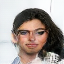

(Image size  = (64, 64, 3)


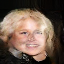

(Image size  = (64, 64, 3)


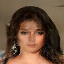

(Image size  = (64, 64, 3)


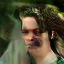

(Image size  = (64, 64, 3)


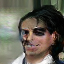

(Image size  = (64, 64, 3)


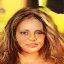

(Image size  = (64, 64, 3)


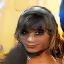

(Image size  = (64, 64, 3)


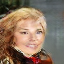

(Image size  = (64, 64, 3)


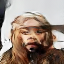

In [12]:






import glob
import PIL
from IPython.display import display # to display images

# Filter out the generate images from the current working directory
generate_imgage_files =glob.glob('/content/images/generated_img_[0-9]*_[0-9].png')

# Plot the latest 9 images
for file in generate_imgage_files[-9:]:
    img = PIL.Image.open(str(file))
    #image mode means the number of channels , each image is #D (H,W, C)
    print(f'(Image size  = ({img.size[0]}, {img.size[0]}, {len(img.mode)})')
    display(img)